In [2]:
import networkx as nx
import os
import glob
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import pickle
import networkx as nx
import matplotlib as mlp
# mlp.use("Qt5Agg")
import matplotlib.pyplot as plt
import community
import scipy

# Functions

### Function to threshold graphs

In [3]:
def threshold(G, corr_direction):
    ##Creates a copy of the graph
    H = G.copy()
    for stock1, stock2, weight in list(G.edges(data=True)):
        if corr_direction == "positive":
            if weight["weight"] <0:
                H.remove_edge(stock1, stock2)
        else:
            if weight["weight"] >=0:
                H.remove_edge(stock1, stock2)
    return(H)

### Function to unpickle data

In [4]:
def onetoughjar(path2dic):
    with open(path2dic, 'rb') as pickle_file:
        try:
            while True:
                output = pickle.load(pickle_file)
        except EOFError:
            pass
    return(output)

### Function to create graphs of all the nodes

In [5]:
def grace_graph(graph, group):
    G=graph
    positions = nx.circular_layout(G)
    size = 100
    title= "Modularity and edge weights \n of average %s graph"%(group)
    save="%s_graph.png"%(group)
    
    edges,weights = zip(*nx.get_edge_attributes(G, 'weight').items())

    nodes, color = zip(*nx.get_node_attributes(G, 'modules').items()) #if your modules are named different change here
    # nodes, names = zip(*nx.get_node_attributes(graph, 'label').items()) #if your modules are named different change here
    
    #Figure size
    plt.figure(figsize=(80,50))

    #draws nodes
    color = np.array(color)
    n_color=len(list(set(color)))
    # nColormap=plt.cm.Set3 #check here if you want different colors https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    cM=color.max()
    cm=color.min()
    # get discrete colormap
    nColormap = plt.get_cmap('Set3', n_color)

    # scaling
    sz=np.array(size)
    scale=15000/sz.max()
    sza=sz*scale
    # print(sz.shape)

    y=nx.draw_networkx_nodes(G,positions,
                           node_color=color,
                           node_size=sza,
                           alpha=0.8,
                           cmap= nColormap,
                           vmin=cm ,vmax=cM)

    #Styling for labels
    nx.draw_networkx_labels(G, positions,
                            # labels = label_dict,
                            font_size=50,
                            font_family='sans-serif',
                            fontweight = 'bold')

    #draw edges
    weights=np.array(weights)
    eColormap=plt.cm.gist_rainbow #check here if you want different colors https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    # scaling
    wt=list(set(weights))
    wt=np.array(wt)
    wt2=-np.sort(-wt)
    wt0=wt2[1]

    escale=1/wt0
    esza=weights*escale
    E=list(set(esza))
    E2=-np.sort(-np.array(E))
    M=1
    m=0

    x=nx.draw_networkx_edges(G, positions,
                           edge_list=edges,
                           style='solid',
                           width = np.square(esza)*20,
                           edge_color = esza,
                           edge_cmap=eColormap,
                           edge_vmin=m,
                           edge_vmax=M)

    #COLORBAR STUFF
    node_bar=plt.colorbar(y, label='Module value')

    tick_locs = (np.arange(n_color) + 0.5)*(n_color-1)/n_color
    node_bar.set_ticks(tick_locs)

    # set tick labels (as before)
    node_bar.set_ticklabels(np.arange(n_color))


    sm = plt.cm.ScalarMappable(cmap=eColormap, norm=plt.Normalize(vmin = m, vmax=M))
    sm._A = []
    edge_bar=plt.colorbar(sm)

    for l in edge_bar.ax.yaxis.get_ticklabels():
        l.set_size(50)
    for l in node_bar.ax.yaxis.get_ticklabels():
        l.set_size(50)
        l.set_verticalalignment('center')

    node_bar.set_label('Modularity',fontsize = 50)
    edge_bar.set_label('Strength of edge weight',fontsize = 50)
    # Final plot stuff
    plt.axis('off')

    plt.title(title, fontsize = 100)
    basepath='/Users/gracer/Google Drive/HCP_graph/1200/images'

    plt.savefig(os.path.join(basepath,save), format="PNG")
    plt.show()
    return()

In [6]:
def module_fig(G, group, IC):
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    #nodes, size = zip(*nx.get_node_attributes(G,'clustering').items())

    positions=nx.circular_layout(G)
    plt.figure(figsize=(80,50))
    ### NODES ####
    color = np.array(list(G.nodes))
    color = np.array(color)
    n_color=len(list(set(color)))
    nColormap = plt.get_cmap('Set3', n_color)

    y=nx.draw_networkx_nodes(G,positions,
                           node_color=color,
                           node_size=15000,
                           alpha=1.0,
                           cmap= nColormap,
                           vmin=0,vmax=n_color )

    #Styling for labels
    nx.draw_networkx_labels(G, positions, font_size=100,
                            font_family='sans-serif', fontweight = 'bold')
    
    ### EDGES ####
    weights=np.array(weights)

    m=weights.min()
    M=weights.max()
    
    eColormap=plt.cm.gist_rainbow
    
    x=nx.draw_networkx_edges(G, positions, 
                             edge_list=edges,
                             style='solid', 
                             width = weights,
                             edge_color = weights, 
                             edge_vmin=m, 
                             edge_vmax=M, 
                             edge_cmap= eColormap)

    
    node_bar=plt.colorbar(y, label='Module value')
    
    tick_locs = (np.arange(n_color) + 0.5)*(n_color-1)/n_color
    node_bar.set_ticks(tick_locs)

    # set tick labels (as before)
    node_bar.set_ticklabels(np.arange(n_color))


    sm = plt.cm.ScalarMappable(cmap=eColormap, norm=plt.Normalize(vmin = m, vmax=M))
    sm._A = []
    edge_bar=plt.colorbar(sm)

    for l in edge_bar.ax.yaxis.get_ticklabels():
        l.set_size(50)
    for l in node_bar.ax.yaxis.get_ticklabels():
        l.set_size(50)
        l.set_verticalalignment('center')

    node_bar.set_label('Modularity',fontsize = 50)
    edge_bar.set_label('Strength of edge weight',fontsize = 50)
    
    plt.title("Module Connectivity Weights %s %s"%(group, IC), fontsize = 100)
    plt.axis('off')
    basepath='/Users/gracer/Google Drive/HCP_graph/1200/images'
#     plt.savefig(os.path.join(basepath,"modularity_%s.png"%(Type)), format="PNG")
    # plt.show()

### Function to create communities

In [7]:
def com_create(mu):
    partition = community.best_partition(mu)
    vals = list(partition.values())
    nx.set_node_attributes(mu, partition, 'modules')
    return((partition,vals, mu))

### Function to generate p values

In [8]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

### Function to visualize the module graphs

In [9]:
def inmod_graph(graph, group):
#     graph=threshold(graph,dirp,minp)
    e,w = zip(*nx.get_edge_attributes(graph, 'weight').items())
    positions = nx.circular_layout(graph)
    size = 100
    title= "Modularity and edge weights \n of average %s graph"%(group)
    save="%s_graph.png"%(group)
    
    edges,weights = zip(*nx.get_edge_attributes(graph, 'weight').items())

    nodes, color = zip(*nx.get_node_attributes(graph, 'modules').items()) #if your modules are named different change here
    # nodes, names = zip(*nx.get_node_attributes(graph, 'label').items()) #if your modules are named different change here
    g=graph
    #Figure size
    plt.figure(figsize=(80,50))

    #draws nodes
    color = np.array(color)
    n_color=len(list(set(color)))
    # nColormap=plt.cm.Set3 #check here if you want different colors https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    cM=color.max()
    cm=color.min()
    # get discrete colormap
    nColormap = plt.get_cmap('Set3', n_color)

    # scaling
    sz=np.array(size)
    scale=15000/sz.max()
    sza=sz*scale
    # print(sz.shape)

    y=nx.draw_networkx_nodes(g,positions,
                           node_color=color,
                           node_size=sza,
                           alpha=0.8,
                           cmap= nColormap,
                           vmin=cm ,vmax=cM)

    #Styling for labels
    nx.draw_networkx_labels(g, positions,
                            # labels = label_dict,
                            font_size=50,
                            font_family='sans-serif',
                            fontweight = 'bold')

    #draw edges
    weights=np.array(weights)
    eColormap=plt.cm.gist_rainbow #check here if you want different colors https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
#     # scaling
#     wt=list(set(weights))
#     wt=np.array(wt)
#     wt2=-np.sort(-wt)
#     wt0=wt2[1]

#     escale=1/wt0
#     esza=weights*escale
#     E=list(set(esza))
#     E2=-np.sort(-np.array(E))
    M=1
    m=-1

    x=nx.draw_networkx_edges(g, positions,
                           edge_list=edges,
                           style='solid',
                           width = np.square(weights)*100,
                           edge_color = weights,
                           edge_cmap=eColormap,
                           edge_vmin=m,
                           edge_vmax=M)

    #COLORBAR STUFF
    node_bar=plt.colorbar(y, label='Module value')

    tick_locs = (np.arange(n_color) + 0.5)*(n_color-1)/n_color
    node_bar.set_ticks(tick_locs)

    # set tick labels (as before)
    node_bar.set_ticklabels(np.arange(n_color))


    sm = plt.cm.ScalarMappable(cmap=eColormap, norm=plt.Normalize(vmin = m, vmax=M))
    sm._A = []
    edge_bar=plt.colorbar(sm)

    for l in edge_bar.ax.yaxis.get_ticklabels():
        l.set_size(50)
    for l in node_bar.ax.yaxis.get_ticklabels():
        l.set_size(50)
        l.set_verticalalignment('center')

    node_bar.set_label('Modularity',fontsize = 50)
    edge_bar.set_label('Strength of edge weight',fontsize = 50)
    # Final plot stuff
    plt.axis('off')

    plt.title(title, fontsize = 100)
    basepath='/Users/gracer/Google Drive/HCP_graph/1200/images'

    plt.savefig(os.path.join(basepath,save), format="PNG")
    plt.show()
    return()

### Function to look at the p values quickly

In [10]:
def skimP(mat):
    mask = np.zeros_like(mat)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(14, 10))
        ax = sns.heatmap(mat, mask=mask,annot=True, center=0.05,square=True, cmap='gist_ncar')
#         ax.set_title(name)

### Function to generate graph and metrics

In [11]:
def mu_make_graphs(key, values, direction):
    ########################################
    cor_matrix = np.asmatrix(values)
    G = nx.from_numpy_matrix(cor_matrix)
    ########################################
    tG = threshold(G, direction)
    if len(list(tG.edges(data=True))) > 0:
        if direction == 'negative':
            print('start negative')
            edges,weights = zip(*nx.get_edge_attributes(tG,'weight').items())
            wts=tuple(abs(np.array(weights)))
            total=[]
            for x in enumerate(edges):
                y={'weight':wts[x[0]]}
                total.append(x[1]+(y,))
            tG.add_edges_from(total)

        ########################################
        (partition,vals,graph)=com_create(tG)
        nx.set_node_attributes(tG, partition, 'modules')
        ########################################
        x=abs(cor_matrix)
        mu=x.mean()
        ########################################
        clustering = nx.clustering(tG, weight=True)
        ########################################
        centrality = nx.betweenness_centrality(tG, weight=True)
        ########################################
        nx.set_node_attributes(tG, centrality, 'centrality')
        nx.set_node_attributes(tG, clustering, 'clustering')
        nx.set_node_attributes(tG, partition, 'modules')

        stocks = values.index.values
        tG = nx.relabel_nodes(tG,lambda x: stocks[x])
        ########################################
        return({'mean_FC':mu, 'graphs':tG, 'clustering_coeff':clustering, 'btn_centrality':centrality,  'modules':{'partition':partition,
    'values':vals,'graph':graph}})
    else:
        print('this is empty')
    

## Base dictionary structure

In [12]:
base_dict={'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           }
          }

## Load in appropriate files
1. Header = These are the ICs from the 15 dimenstion
2. labels = These are labels from the glasser and gordon merged brains (allowing for cortex and subcortex)
3. covars = These are the values of BMI, age at onset of menses, race, age, and head motion. The same file was used in FSLNETS

In [43]:
header=['IC1','IC2','IC3','IC4','IC5','IC6','IC7','IC8','IC9','IC10','IC11','IC12','IC13','IC14','IC15']

In [44]:
labels = pd.read_csv('/Users/gracer/Google Drive/HCP_graph/1200/brains/lables_glasser.csv', sep=',')

In [45]:
covars=pd.read_csv('/Users/gracer/Google Drive/HCP_graph/1200/datasets/subs510.csv', sep=',', header=None)

In [46]:
covars.columns=['idx','subject','group','BMI','AoM','int','race','age','motion']

In [47]:
covars.drop_duplicates(subset='subject', keep="last", inplace=True)

In [48]:
covars.shape

(510, 9)

In [49]:
covars['subject']=covars['subject'].astype('int64')

In [50]:
high_low=pd.read_csv('/Users/gracer/Google Drive/HCP_graph/1200/datasets/post_hoc.csv', sep=',')

In [51]:
hl=high_low[['Subject','AoM']]
hl=hl.dropna()
hl.columns = ["subject", "high_low"]

### Load in all timeseries data from each participant into data_dict. 
These are the netmat2 files. They are zscores per TR

In [52]:
raw_dict={'late':hl.loc[hl['high_low']=='late'],'early': hl.loc[hl['high_low'] == 'early']}
data_dict={'late':{},'early':{}}
for key, df in raw_dict.items():
    print(key)
    for sub in df['subject']:
        path=os.path.join(
            '/Users/gracer/Downloads/HCP_S1200_PTNmaps_d15_25_50_100/3T_HCP1200_MSMAll_d15_ts2_Z/puberty/%i.txt'%sub)
        data_dict[key][sub]=pd.read_csv(path,sep='\t',names=header)

late


FileNotFoundError: [Errno 2] File b'/Users/gracer/Downloads/HCP_S1200_PTNmaps_d15_25_50_100/3T_HCP1200_MSMAll_d15_ts2_Z/puberty/101006.txt' does not exist: b'/Users/gracer/Downloads/HCP_S1200_PTNmaps_d15_25_50_100/3T_HCP1200_MSMAll_d15_ts2_Z/puberty/101006.txt'

In [53]:
len(list(data_dict['early'].keys()))

0

Check that you have 212 subjects/files

## Subset the ICs of interest
Don't need all the ICs. Just the ones already associated with BMI and puberty. This allows us to look at the relationships within IC.

In [ ]:
interest

In [ ]:
interest={'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           }
          }
for t, dt in interest.items():
    print(t)
    for x,y in dt.items():
        print(x)
        for k,v in y.items():
            print(k)
            for key, value in data_dict[t].items():
                v[key]=value[k]    

## Create datatables with the rows as subjects and columns as parcels per IC

From here on we will seperate all ICs from each other. This allows us to look at the parcellation per IC. The dfs is a dictionary of all ICs of interest. The columns are the parcels and rows are the subjects.

In [17]:
dfs = {'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           }
          }
for t, df in interest.items():
    for group, value in df.items():
        for IC,v in value.items():
            x=pd.DataFrame.from_dict(v, orient='index')
            print(x.shape)
            x['subject']=x.index
            x['subject'] = x['subject'].astype('int64')
            hl['subject']= hl['subject'].astype('int64')
            y=pd.merge(x, covars, left_on='subject', right_on='subject')
            print(y.shape)
            z=pd.merge(y, hl, left_on='subject', right_on='subject')
            print(z.shape)
            del z['group']
            del z['idx']
            z.set_index('subject', inplace=True)
            dfs[t][group][IC]=z

NameError: name 'interest' is not defined

In [19]:
dfs['late']['BMI']['IC1']

{}

In [21]:
for t, item in dfs.items():
    for group, value in item.items():
        for IC, v in value.items():
            del v['idx']
            dfs[t][group][IC]=v

## Thresholding the zscores 
Only keeping zscores > 3.5 and greater than 75 of the participants must have a value for the score to keep the column. This is to threshold out noise and missing data

In [22]:
zscores_thr= {'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           }
          }

for t, df in dfs.items():
    for group, value in df.items():
        print(group)
        for IC,v in value.items():
            print(IC)
            x = v[(v.iloc[:,1:379]>3.5) | (v.iloc[:,1:379]<-3.5)]
            y=x.dropna(axis=1, how='all')
            test=y.isna().mean()
            q = y.loc[:, y.isna().mean() < .25]
            z=pd.concat([v.iloc[:,379:], q], axis=1)
            zscores_thr[t][group][IC]=z

BMI
IC1
IC3
IC4
IC5
IC6
IC7
IC8
IC9
IC10
IC11
IC12
IC13
IC14
IC15
AoM
IC12
IC15
int
IC2
IC3
IC6
IC12
IC13
BMI
IC1
IC3
IC4
IC5
IC6
IC7
IC8
IC9
IC10
IC11
IC12
IC13
IC14
IC15
AoM
IC12
IC15
int
IC2
IC3
IC6
IC12
IC13


In [23]:
zscores_thr['early']['BMI']['IC1'].shape

(87, 40)

# Generating the graphs with positive values

## Important
### Correlations
This is probably the most important part. Here we are taking our (subxparcel) dataframes we thresholded above and we are generating a correlation matrix using a Pearson's Product correlation (R). Within each matrix, there will be positive and negative correlation values. This can be a problem with the graph metrics we want to use.
### Graphs
To avoid the issue of negative and positive values, we are going to threshold each correlation matrix twice. 
1. Positive correlations
2. Negative correltions

We will then use the absolute value of the negative correlations to mimic a positive correlation. We will keep these seperate for the rest of the analysis.

In [25]:
graphs = {'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}}}

for t, item in zscores_thr.items():
    for group, value in item.items():
#         print(key)
        for IC, v in value.items():
            print(group)
            graphs[t][group][IC]=mu_make_graphs(IC, v.corr(), 'positive')


BMI
BMI
BMI
BMI
BMI
BMI
BMI
BMI
BMI
BMI
BMI
BMI
BMI
BMI
AoM
AoM
int
int
int
int
int
BMI
BMI
BMI
BMI
BMI
BMI
BMI
BMI
BMI
BMI
BMI
BMI
BMI
BMI
AoM
AoM
int
int
int
int
int


## Generating graphs with negative values
Unable to get communities with negative values need to keep seperate

In [26]:
nega_graphs = {'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}}}

for t, item in zscores_thr.items():
    for group, value in item.items():
        print(group)
        for IC, v in value.items():
            print(IC)
            nega_graphs[t][group][IC]=mu_make_graphs(IC, v.corr(), 'negative')


BMI
IC1
start negative
IC3
start negative
IC4
start negative
IC5
start negative
IC6
start negative
IC7
start negative
IC8
start negative
IC9
start negative
IC10
start negative
IC11
start negative
IC12
start negative
IC13
start negative
IC14
start negative
IC15
start negative
AoM
IC12
start negative
IC15
start negative
int
IC2
start negative
IC3
start negative
IC6
start negative
IC12
start negative
IC13
start negative
BMI
IC1
start negative
IC3
start negative
IC4
start negative
IC5
start negative
IC6
start negative
IC7
start negative
IC8
start negative
IC9
start negative
IC10
start negative
IC11
start negative
IC12
start negative
IC13
start negative
IC14
start negative
IC15
start negative
AoM
IC12
start negative
IC15
start negative
int
IC2
start negative
IC3
start negative
IC6
start negative
IC12
start negative
IC13
start negative


## Visualizing the total graphs for all ICs in the interaction group

These graphs will show all the nodes in each IC (positive and negative). It will also show what community each node belongs to. Community struture will be a measure of density. Denser connections will form modules. 

In [ ]:
for key, value in graphs['late']['int'].items():
    grace_graph(value['graphs'], 'Int_%s'%key)

In [ ]:
for key, value in nega_graphs['late']['int'].items():
    grace_graph(value['graphs'], 'Int_%s'%key)

## writing all the adjacency matrices and topologocial values to csv to save

In [ ]:
# for key, value in graphs.items():
#     print(key)
#     for k, v in value.items():
#         print(k)
#         cc=pd.DataFrame.from_dict(v['clustering_coeff'], orient='index')
#         btw=pd.DataFrame.from_dict(v['btn_centrality'], orient='index')
#         mod=pd.DataFrame.from_dict(v['modules']['partition'], orient='index')
#         test3 = pd.concat([cc, btw, mod], axis=1)
#         test3.columns = ['cc','btw','mod']
#         print(test3.shape)
#         test3.set_index([list(zscores_thr[key][k].columns.values)], inplace=True)
#         adj=nx.to_pandas_adjacency(v['graphs'])
#         print(adj.shape)
#         df=adj.merge(test3, left_index=True, right_index=True)
#         pd.DataFrame.to_csv(df, '/Users/gracer/Google Drive/HCP_graph/1200/datasets/%s_%s_thresh.csv'%(key,k))

In [ ]:
# for key, value in nega_graphs.items():
#     print(key)
#     for k, v in value.items():
#         print(k)
#         cc=pd.DataFrame.from_dict(v['clustering_coeff'], orient='index')
#         btw=pd.DataFrame.from_dict(v['btn_centrality'], orient='index')
#         test3 = pd.concat([cc, btw], axis=1)
#         test3.columns = ['cc','btw']
#         test3.set_index([list(zscores_thr[key][k].columns.values)], inplace=True)
#         pd.DataFrame.to_csv(test3, '/Users/gracer/Google Drive/HCP_graph/1200/datasets/%s_%s_thresh_neg.csv'%(key,k))

## Visualizing the within module graph 
These are graphs that look at the connectivity within each module. This shows us how the most related areas (densely connected) interact with each other. 

In [27]:
subgraphs = {'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}}}

for t, item in graphs.items():
    for group, v in item.items():
        for IC, value in v.items():
            print(IC)
            G=value['graphs']
            mod=G.nodes(data=True)[group]['modules']
            print(mod)
            interest=[k for k,v in nx.get_node_attributes(G, 'modules').items() if v == mod]
            print(interest)
            X=nx.subgraph(G, interest)
            subgraphs[t][group][IC]=X
#             inmod_graph(X, 'interaction')

IC1
0
['BMI', 'int', 'race', 'age', 'motion', 68, 134, 135, 314, 315]
IC3
0
['BMI', 'int', 'age', 'motion']
IC4
0
['BMI', 'AoM', 'int', 'race', 'age', 'motion']
IC5
0
['BMI', 'int', 'race', 'age', 'motion', 87, 89]
IC6
0
['BMI', 'int', 'race', 'age', 'motion', 163, 224]
IC7
0
['BMI', 'int', 'race', 'age', 'motion', 264]
IC8
0
['BMI', 'int']
IC9
0
['BMI', 'AoM', 'int', 'race', 'age', 'motion']
IC10
0
['BMI', 'int', 'race', 'age', 'motion']
IC11
0
['BMI', 'int', 'race', 'age', 'motion']
IC12
0
['BMI', 'int', 'age', 'motion']
IC13
0
['BMI', 'int', 'race', 'age', 'motion']
IC14
0
['BMI', 'int', 'race', 'age', 'motion', 99]
IC15
0
['BMI', 'int', 'race', 'age', 'motion']
IC12
1
['AoM', 'race']
IC15
1
['AoM']
IC2
0
['BMI', 'int', 'race', 'age', 'motion', 162]
IC3
0
['BMI', 'int', 'age', 'motion']
IC6
0
['BMI', 'int', 'race', 'age', 'motion', 163, 224]
IC12
0
['BMI', 'int', 'age', 'motion']
IC13
0
['BMI', 'int', 'race', 'age', 'motion']
IC1
0
['BMI', 'race', 'motion']
IC3
0
['BMI', 'age', 'mot

# Summary
Overall, within each module the interaction term is segregated. These are positive graphs, therefore they are either increasing or decreasing together. This indicates to me that the interaction is fairly unique and not densely correlated. It maybe that is it correlated more strongly to other modules. 

In [28]:
nega_subgraphs = {'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}}}

for t, item in nega_graphs.items():
    for group, v in item.items():
        for IC, value in v.items():
            print(IC)
            G=value['graphs']
            mod=G.nodes(data=True)[group]['modules']
            print(mod)
            interest=[k for k,v in nx.get_node_attributes(G, 'modules').items() if v == mod]
            print(interest)
            X=nx.subgraph(G, interest)
            nega_subgraphs[t][group][IC]=X
#             inmod_graph(X, 'interaction')

IC1
0
['BMI', 'AoM', 'int', 24, 38, 39, 68, 174, 218, 354]
IC3
0
['BMI', 'AoM', 'int', 'motion', 40, 199, 203, 220]
IC4
0
['BMI', 'AoM', 'int', 28, 35, 37, 39, 66, 67, 113, 156, 170, 172, 200, 205, 214, 215, 246, 336, 350, 352, 354]
IC5
0
['BMI', 'AoM', 'int', 68, 163, 209, 210, 283, 293, 331, 336, 344]
IC6
0
['BMI', 'AoM', 'int', 'race', 56, 60, 63, 117, 132, 155, 158, 161, 236, 314, 338, 339]
IC7
0
['BMI', 'AoM', 'int', 88, 89, 103, 105, 115, 116, 151, 168]
IC8
0
['BMI', 'AoM', 'int', 'motion']
IC9
0
['BMI', 'int', 47, 48, 64, 145, 155, 169, 180, 228, 243, 266, 325, 344, 349]
IC10
0
['BMI', 'AoM', 'int', 30, 44, 168, 179, 223, 267, 268, 277, 326, 328, 348]
IC11
0
['BMI', 'AoM', 'int', 70, 165, 244, 247, 248, 249, 250, 294, 299, 355]
IC12
0
['BMI', 'AoM', 'int', 'motion', 22, 23, 31, 202, 203, 314]
IC13
0
['BMI', 'AoM', 'int', 27, 42, 118, 120, 122, 165, 186, 207, 210, 302, 303]
IC14
0
['BMI', 'AoM', 'int', 104, 227, 269, 283, 377]
IC15
0
['BMI', 'motion', 32, 33, 163, 179, 212, 213, 

# Summary
we can see that the inverse correlations are overall much weaker than the positive. Further, the interaction term is positively correlated with BMI and head motion, but negatively correlated with age at onset of menses. This is expected since the relationship between BMI and age at onset of menses is inverse. (see R notebook)

## Creating module based graphs

In [29]:
community_graphs= {'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}}}
for t, item in graphs.items():
    for group, v in item.items():
        for IC, data in v.items():
            comm_graph = community.induced_graph(data['modules']['partition'], 
                                            data['modules']['graph'])
            community_graphs[t][group][IC]=comm_graph
            print(IC)
#             module_fig(comm_graph, group, IC)

IC1
IC3
IC4
IC5
IC6
IC7
IC8
IC9
IC10
IC11
IC12
IC13
IC14
IC15
IC12
IC15
IC2
IC3
IC6
IC12
IC13
IC1
IC3
IC4
IC5
IC6
IC7
IC8
IC9
IC10
IC11
IC12
IC13
IC14
IC15
IC12
IC15
IC2
IC3
IC6
IC12
IC13


# Summary
The module graphs show that the connectivity of the modules containing the interaction term are rather weak. Especially in IC3 and IC12 (module 2), they are only weakly related to the other modules. In ICs 4 and 13 we see a more robust response. This suggest to me that 4 and 12 are driving their respective connections with 3 and 12. 

In [30]:
nega_community_graphs= {'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}}}

for t, item in nega_graphs.items():
    for group, v in item.items():
        for IC, data in v.items():
            comm_graph = community.induced_graph(data['modules']['partition'], 
                                            data['modules']['graph'])
            nega_community_graphs[t][group][IC]=comm_graph
            print(IC)
#             module_fig(comm_graph, group, IC)

IC1
IC3
IC4
IC5
IC6
IC7
IC8
IC9
IC10
IC11
IC12
IC13
IC14
IC15
IC12
IC15
IC2
IC3
IC6
IC12
IC13
IC1
IC3
IC4
IC5
IC6
IC7
IC8
IC9
IC10
IC11
IC12
IC13
IC14
IC15
IC12
IC15
IC2
IC3
IC6
IC12
IC13


In [31]:
community_graphs['late']['int']['IC6'].nodes(data=True)

NodeDataView({0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}})

# Summary
There are far fewer nodes and modules in the negative correlation graphs. Interestingly, in the IC2 and IC3 the module with the interaction term is different (0 vs. 2). It appears IC2 is driving the inverse relationship. 

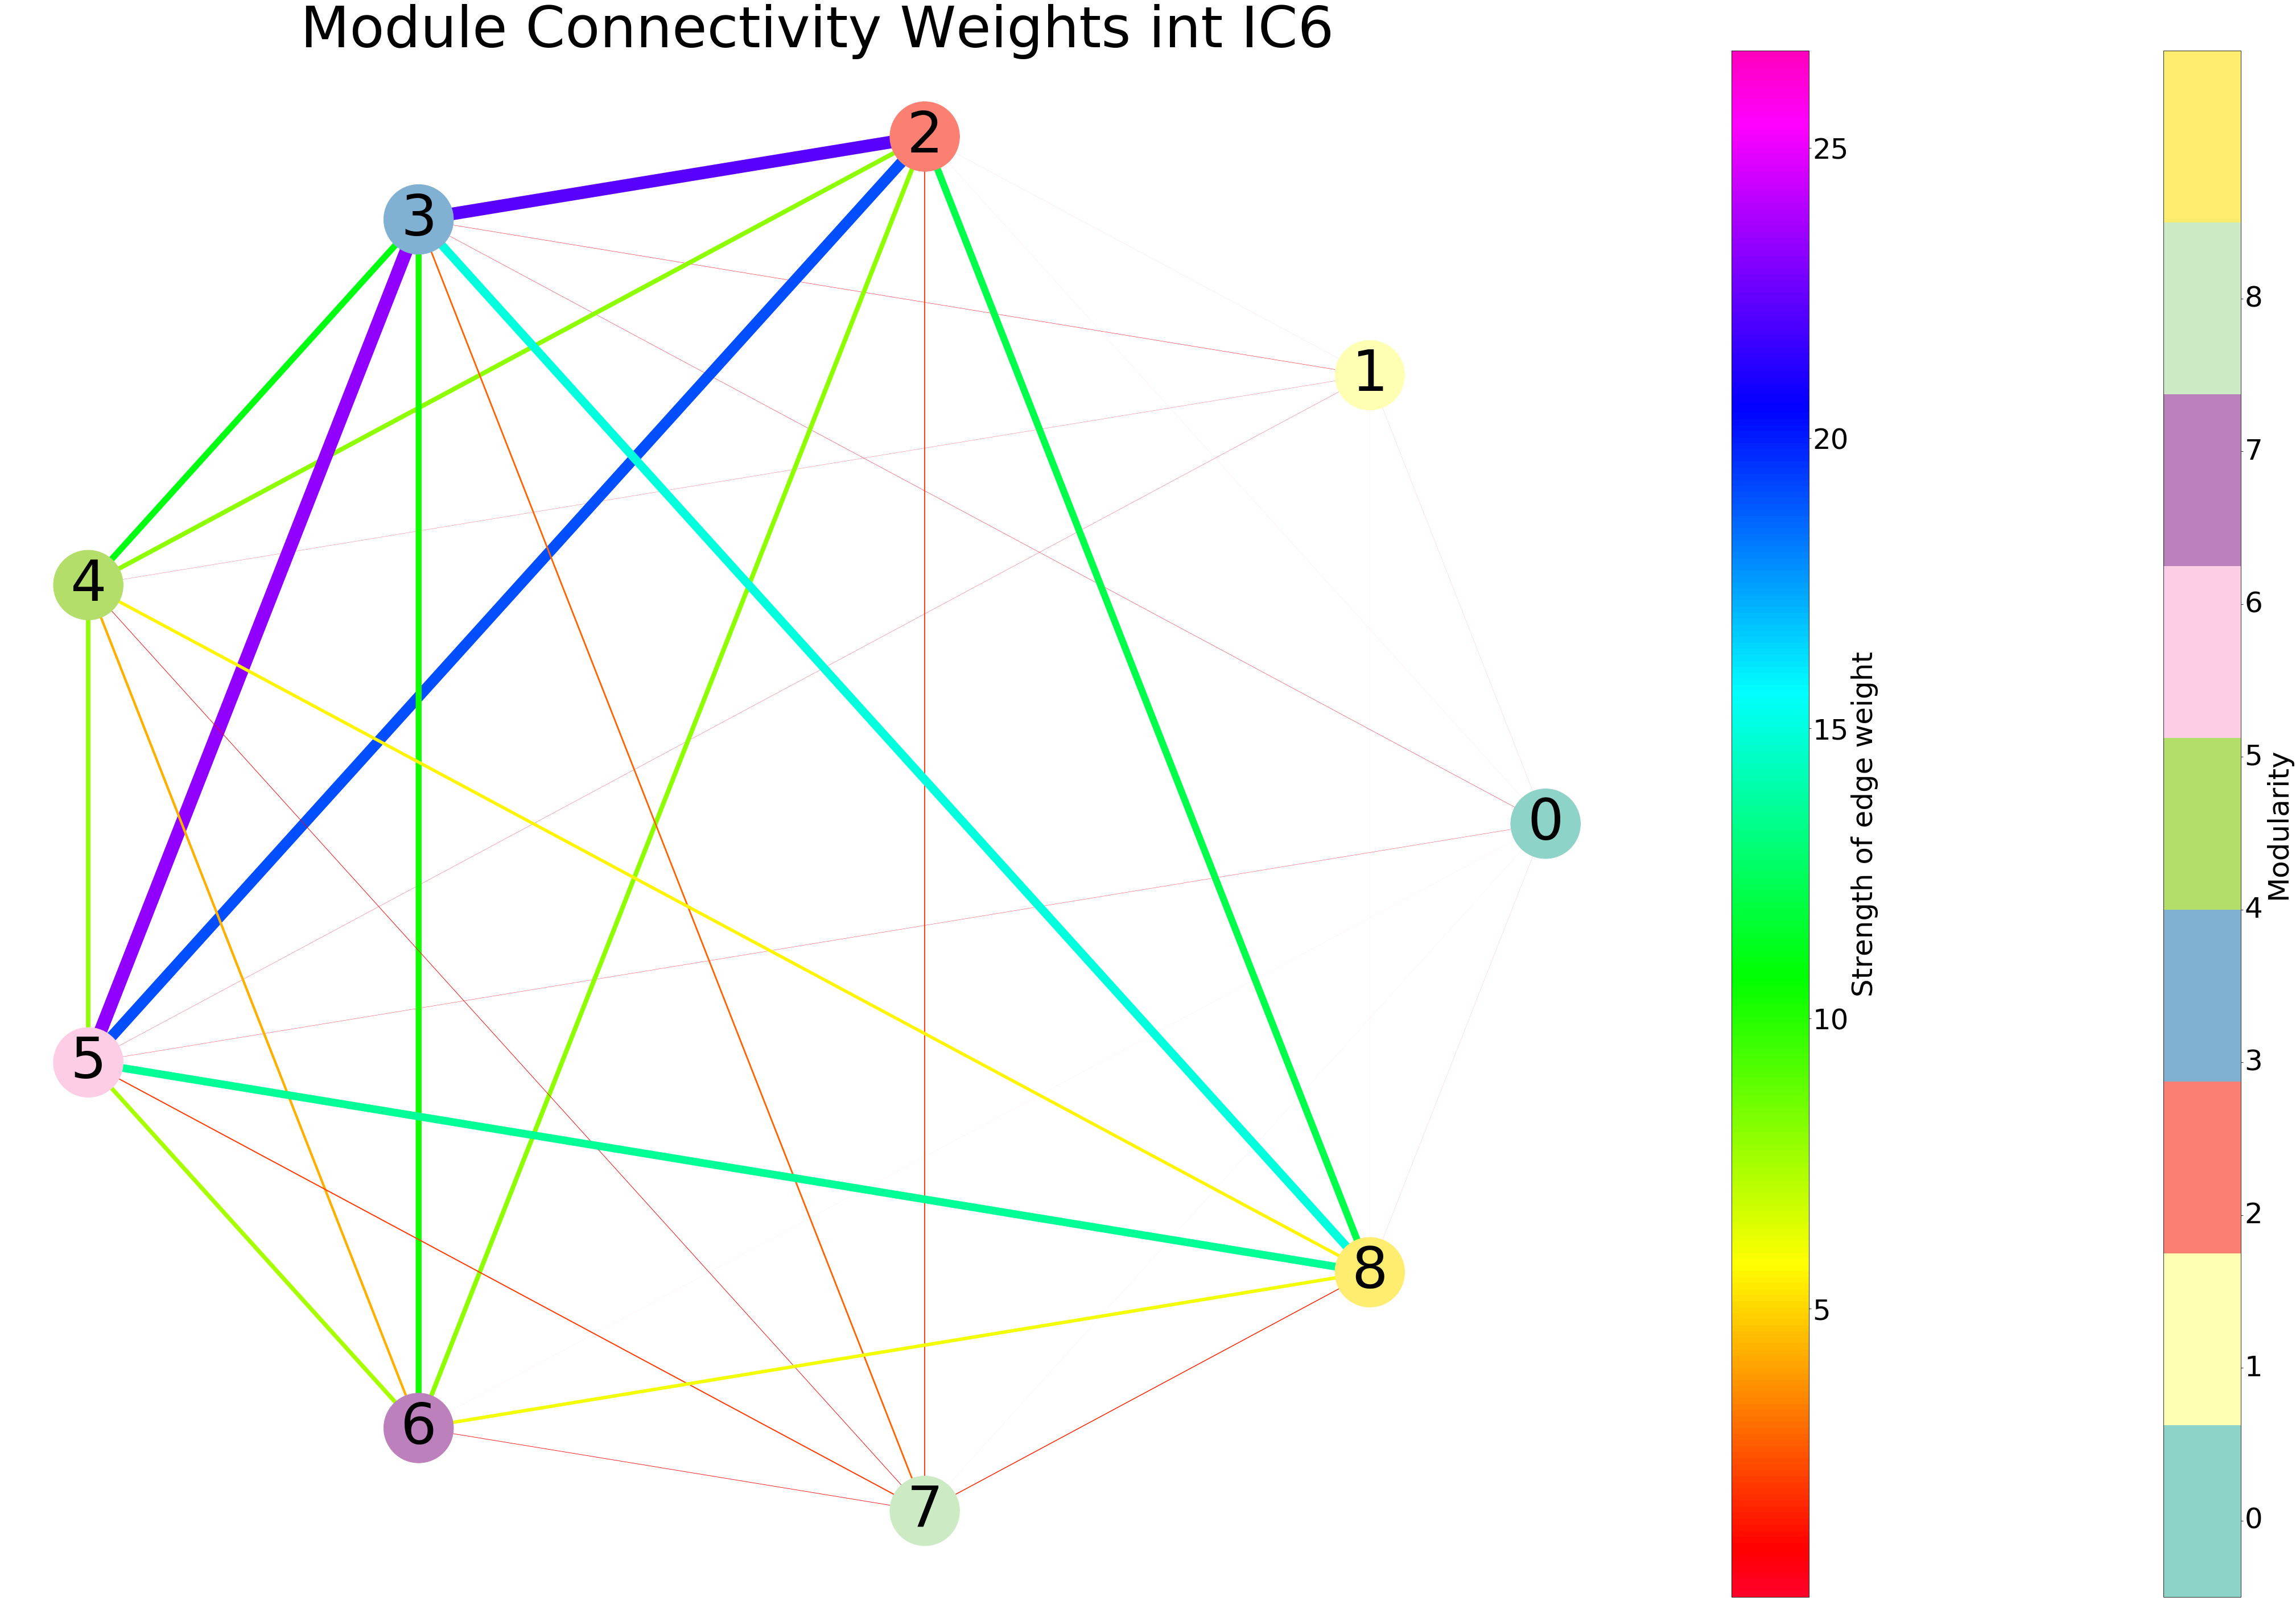

In [32]:
module_fig(community_graphs['late']['int']['IC6'], 'int', 'IC6')

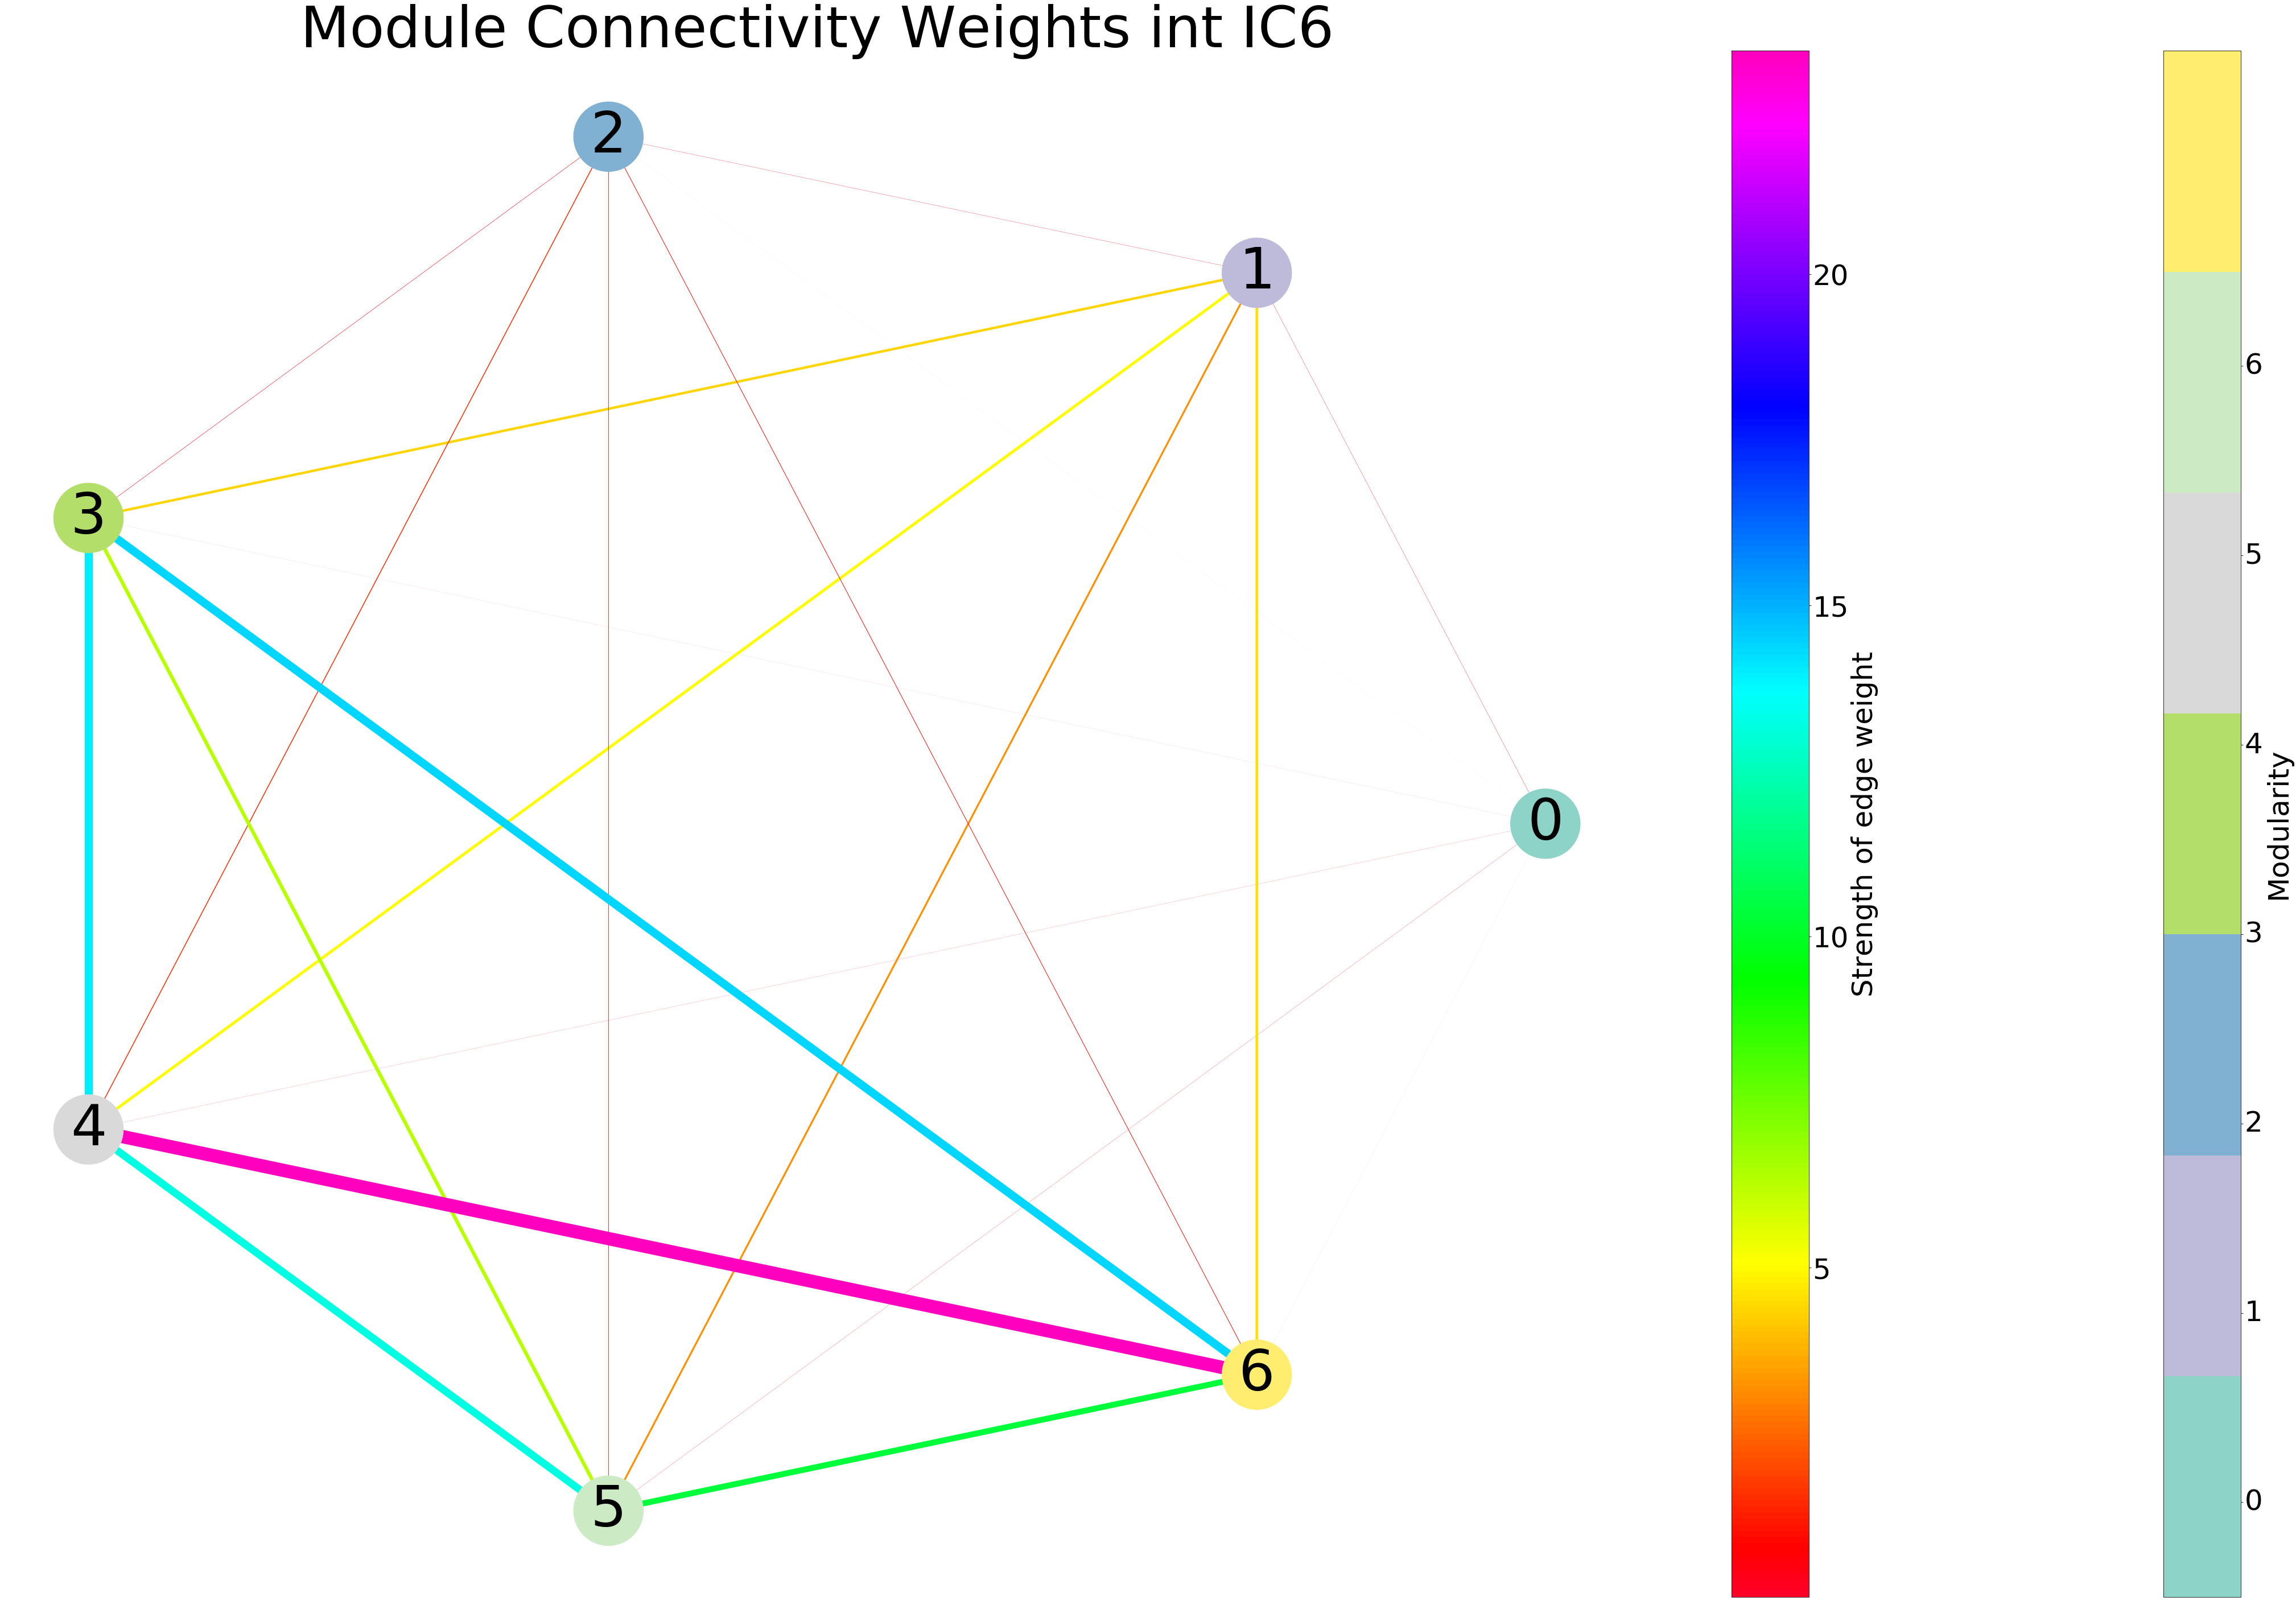

In [33]:
module_fig(community_graphs['early']['int']['IC6'], 'int', 'IC6')

In [34]:
subgraphs['late']['int']['IC6'].nodes(data=True)

NodeDataView({224: {'modules': 0, 'centrality': 0.00019357336430507162, 'clustering': 0.9333333333333333}, 163: {'modules': 0, 'centrality': 0.007837247008345483, 'clustering': 0.5}, 'int': {'modules': 0, 'centrality': 0.009368950832365466, 'clustering': 0.5333333333333333}, 'age': {'modules': 0, 'centrality': 0.01929470975382023, 'clustering': 0.48484848484848486}, 'BMI': {'modules': 0, 'centrality': 0.006129362314031303, 'clustering': 0.5833333333333334}, 'motion': {'modules': 0, 'centrality': 0.001531994911785852, 'clustering': 0.7619047619047619}, 'race': {'modules': 0, 'centrality': 0.03450670811756453, 'clustering': 0.5441176470588235}})

In [35]:
G=graphs['late']['int']['IC6']['graphs']
n2,btw = zip(*nx.get_node_attributes(G, 'centrality').items())
e,w = zip(*nx.get_edge_attributes(G, 'weight').items())

In [46]:
print(pd.DataFrame(list(btw)).shape)

(43, 1)


In [54]:
exports= {'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}}}

nodelist=[]
edgelist=[]
for t, item in graphs.items():
    for group, value in item.items():
        for IC, v in value.items():
            e,w = zip(*nx.get_edge_attributes(v['graphs'], 'weight').items())
            edf = pd.DataFrame(list(e),columns=['x','y'])
            edf['edge_weight']=list(w)
            edf['group']=group
            edf['early_late']=t
            edf['IC']=IC
            n1,cc = zip(*nx.get_node_attributes(v['graphs'], 'clustering').items())
            df=pd.DataFrame(list(cc),columns=['cc'])
            n2,btw = zip(*nx.get_node_attributes(v['graphs'], 'centrality').items())
            df['btw']=list(btw)
            n3,mod = zip(*nx.get_node_attributes(v['graphs'], 'modules').items())
            df['module']=list(mod)
            df['group']=group
            df['early_late']=t
            df['IC']=IC
            exports[t][group][IC]=df
            nodelist.append(df)
            edgeliste.append(edf)
        
            

node_df=pd.concat(nodelist)
ed_df=pd.concat(nodelist)

38
(38, 1)
38
16
(16, 1)
16
59
(59, 1)
59
46
(46, 1)
46
43
(43, 1)
43
35
(35, 1)
35
6
(6, 1)
6
45
(45, 1)
45
39
(39, 1)
39
31
(31, 1)
31
19
(19, 1)
19
44
(44, 1)
44
23
(23, 1)
23
28
(28, 1)
28
19
(19, 1)
19
28
(28, 1)
28
37
(37, 1)
37
16
(16, 1)
16
43
(43, 1)
43
19
(19, 1)
19
44
(44, 1)
44
39
(39, 1)
39
16
(16, 1)
16
59
(59, 1)
59
43
(43, 1)
43
34
(34, 1)
34
34
(34, 1)
34
6
(6, 1)
6
48
(48, 1)
48
38
(38, 1)
38
25
(25, 1)
25
18
(18, 1)
18
43
(43, 1)
43
25
(25, 1)
25
27
(27, 1)
27
18
(18, 1)
18
27
(27, 1)
27
39
(39, 1)
39
16
(16, 1)
16
34
(34, 1)
34
18
(18, 1)
18
43
(43, 1)
43


In [55]:
exports['late']['BMI']['IC1']

,cc,btw,module,group,early_late,IC
0,0.866667,0.001185,0,BMI,late,IC1
1,0.773684,0.012698,1,BMI,late,IC1
2,0.872727,0.001335,0,BMI,late,IC1
3,0.472222,0.004663,0,BMI,late,IC1
4,0.757576,0.004015,0,BMI,late,IC1
5,0.685714,0.007510,0,BMI,late,IC1
6,0.841379,0.013627,2,BMI,late,IC1
7,0.939153,0.002104,3,BMI,late,IC1
8,0.901478,0.004325,3,BMI,late,IC1
9,0.894089,0.004870,3,BMI,late,IC1


In [ ]:
inmod_graph(X, 'interaction')

In [33]:
ALL_DATA={'interest':interest,
'dfs':dfs,
'zscores_thr':zscores_thr,
'graphs':graphs,
'nega_graphs':nega_graphs,
'subgraphs':subgraphs,
'community_graphs':community_graphs}

In [ ]:
ALL_DATA['community_graphs']['late']['BMI']['IC1']

In [34]:
pickle.dump(ALL_DATA, open('/Users/gracer/Google Drive/HCP_graph/1200/datasets/finalhl.pkl', 'wb'), protocol=4)

In [13]:
ALL_DATA=onetoughjar('/Users/gracer/Google Drive/HCP_graph/1200/datasets/finalhl.pkl')

In [20]:
dfs=ALL_DATA['dfs']
graphs=ALL_DATA['graphs']
zscores_thr=ALL_DATA['zscores_thr']
nega_graphs=ALL_DATA['nega_graphs']
dfs=ALL_DATA['dfs']
subgraphs=ALL_DATA['subgraphs']
community_graphs=ALL_DATA['community_graphs']